In [1]:
import sys as SYS; SYS.path.insert(0, '..')
import os

from collections import defaultdict
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

from src import (
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo
import networkx as nx
import itertools
from itertools import combinations

In [17]:
def find_connected_pairs(adjacency_matrix):
    connected_pairs = []
    num_nodes = len(adjacency_matrix)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):  # Ensure we only consider distinct pairs
            if adjacency_matrix[i][j] == 1:  # If there's a connection between nodes i and j
                connected_pairs.append([i, j])  # Use a list [i, j] instead of a tuple (i, j)

    return connected_pairs

def find_two_node_subgroups(adjacency_matrix, num_pairs):
    connected_pairs = find_connected_pairs(adjacency_matrix)
    num_nodes = len(adjacency_matrix)

    all_subgroups = []

    def is_valid(curr_pair):
        nodes = [node for pair in curr_pair for node in pair]
        return len(set(nodes)) == num_nodes

    def backtrack(curr_pair, remaining_pairs):
        if len(curr_pair) == num_pairs:
            sorted_curr_pair = sorted(curr_pair)
            if is_valid(sorted_curr_pair):
                all_subgroups.append(sorted_curr_pair)
            return

        for pair in remaining_pairs:
            if all(node not in [n for p in curr_pair for n in p] for node in pair):
                curr_pair.append(pair)
                next_pairs = [p for p in remaining_pairs if p != pair]
                backtrack(curr_pair, next_pairs)
                curr_pair.pop()

    backtrack([], connected_pairs)

    # Remove duplicates
    unique_subgroups = {frozenset(map(tuple, subgroup)) for subgroup in all_subgroups}
    unique_subgroups = [list(map(list, subgroup)) for subgroup in unique_subgroups]

    # Convert the result to a list of np.array
    unique_subgroups_np = [np.array(subgroup) for subgroup in unique_subgroups]

    return unique_subgroups_np

# Function to plot the adjacency matrix
def plot_adjacency_matrix(adjacency_matrix):
    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='binary', interpolation='none')
    plt.title('Adjacency Matrix')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    plt.colorbar()
    plt.show()

def plot_chosen_pairs(adjacency_matrix, chosen_pairs):
    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='binary', interpolation='none')
    plt.title('Adjacency Matrix with Chosen Pairs')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')

    # Plot chosen pairs
    for pair in chosen_pairs:
        plt.plot(pair, pair, color='red')  # Plot each pair

    plt.colorbar()
    plt.show()

def plot_network_graph(adjacency_matrix):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)

    G = nx.from_numpy_array(adj_matrix)
    pos = nx.circular_layout(G)

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, edge_color='gray', width=2)

    # Add edges based on the adjacency matrix
    #for i in range(num_nodes):
    #    for j in range(i+1, num_nodes):
    #        if adjacency_matrix[i][j] == 1:
    #            G.add_edge(i, j)

    plt.title('Network Graph')
    plt.show()

# Function to plot the network graph with highlighted pairs
def plot_network_graph_with_highlight(adjacency_matrix, chosen_pairs):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)

    # Add edges based on the adjacency matrix
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)
    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Define positions for nodes
    # You can use a layout that suits your needs; here we use circular layout
    # which is good for small graphs.
    # You can also use other layouts like spring_layout, shell_layout, etc.
    # For larger graphs, consider using a layout that minimizes overlap.
    # For example, you can use nx.spring_layout(G) for a force-directed layout.
    # For a circular layout, use:
    # pos = nx.circular_layout(G)
    # For a spring layout, use:
    # pos = nx.spring_layout(G)
    # For a shell layout, use:
    # pos = nx.shell_layout(G)
    # Here we use the circular layout for simplicity.
    # You can change the layout as needed.
    # For larger graphs, consider using a layout that minimizes overlap.
    # For example, you can use nx.spring_layout(G) for a force-directed layout.
    # For a circular layout, use:
    # pos = nx.circular_layout(G)
    # For a spring layout, use:
    # pos = nx.spring_layout(G)
    # For a shell layout, use:
    # pos = nx.shell_layout(G)
    pos = nx.circular_layout(G)  # Positions for all nodes

    plt.figure(figsize=(8, 8))

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=12)

    # Highlight chosen pairs
    for pair in chosen_pairs:
        nx.draw_networkx_edges(G, pos, edgelist=[pair], width=2, edge_color='orange')
        nx.draw_networkx_nodes(G, pos, nodelist=pair, node_color='lightblue', node_size=1000)

    plt.title('Network Graph with Highlighted Pairs')
    plt.show()

In [3]:
n=12
def generate_pairs(objects):
    if len(objects) % 2 != 0:
        raise ValueError("Number of objects must be even to form pairs.")

    # Generate all possible pairs of objects
    pairs = list(itertools.combinations(objects, 2))

    # Function to check if a set of pairs is valid (no overlapping objects)
    def is_valid_combination(pair_comb):
        seen = set()
        for pair in pair_comb:
            if pair[0] in seen or pair[1] in seen:
                return False
            seen.update(pair)
        return True

    # Generate all unique combinations of pairs
    pair_combinations = list(itertools.combinations(pairs, len(objects) // 2))

    # Filter valid combinations
    valid_combinations = [comb for comb in pair_combinations if is_valid_combination(comb)]

    # Convert each combination to a numpy array of lists
    valid_combinations = [np.array([list(pair) for pair in comb]) for comb in valid_combinations]

    return valid_combinations

Unique subgroups of pairs as np.array:
[array([[0, 1],
       [2, 3]])]


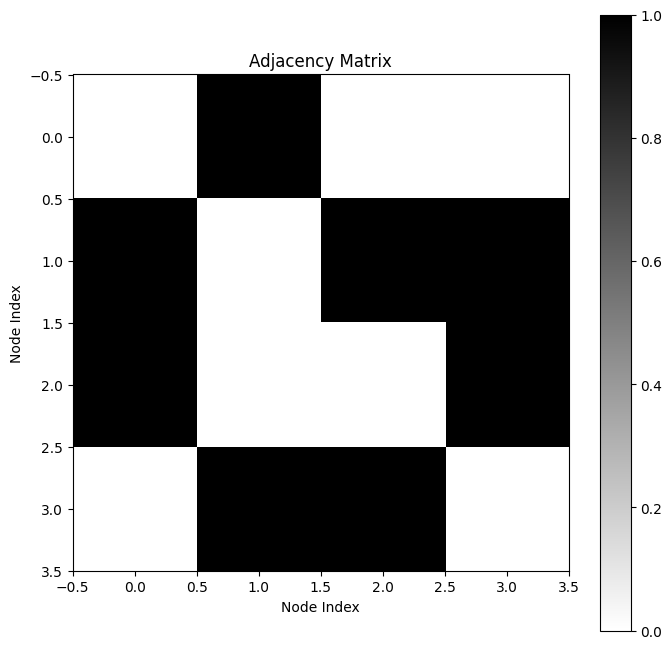

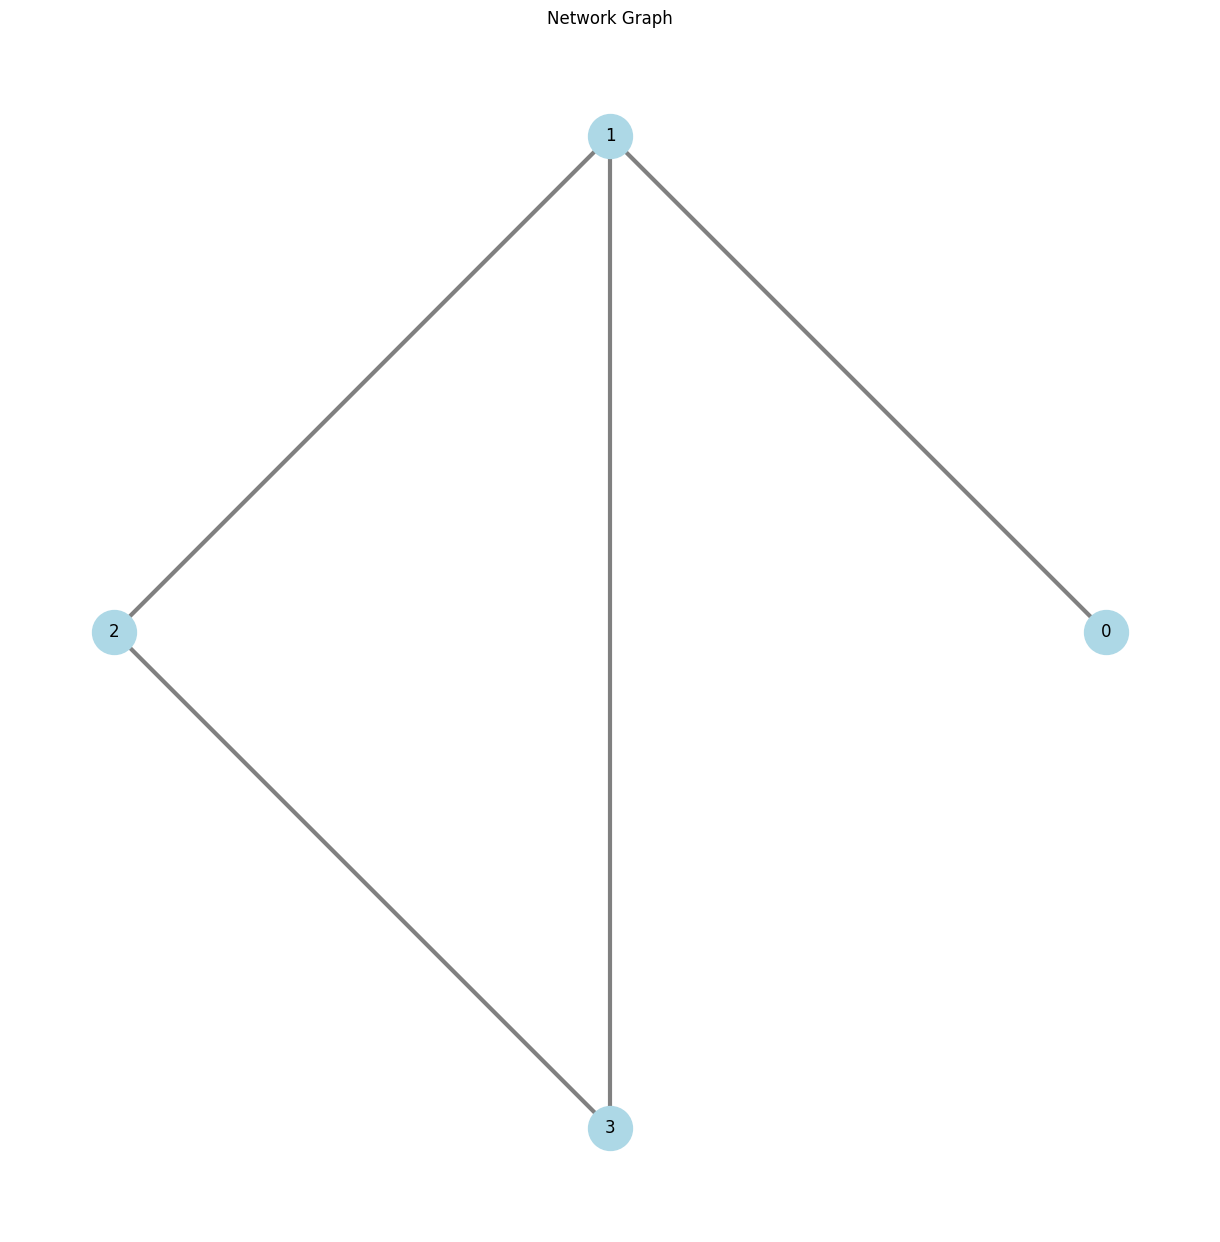

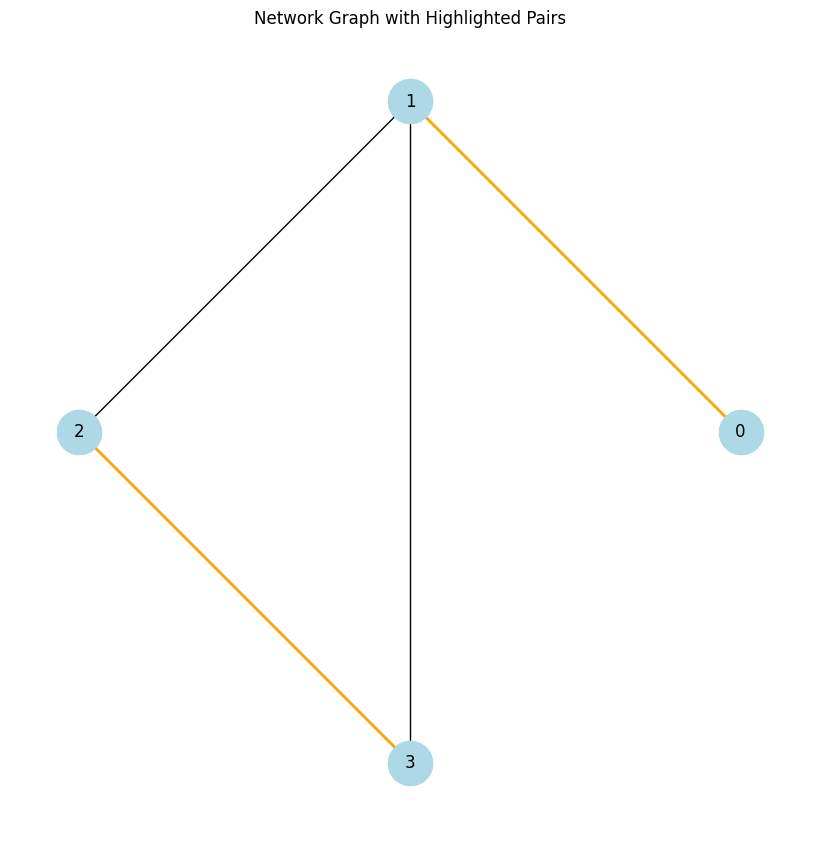

In [5]:
adj_matrix = [
    [0, 1,0,0],
    [1,0,1,1],
    [1,0,0,1],
    [0,1,1,0]

]
#num_pairs should be the K division you want. For two qubit gates we look for K2 subdivisions.
num_pairs = 2
subgroups = find_two_node_subgroups(adj_matrix, num_pairs)
print("Unique subgroups of pairs as np.array:")
print(subgroups)

plot_adjacency_matrix(adj_matrix)
plot_network_graph(adj_matrix)

# Plot the network graph with highlighted pairs
chosen_pairs=[(0, 1),(2, 3)]
plot_network_graph_with_highlight(adj_matrix, chosen_pairs)

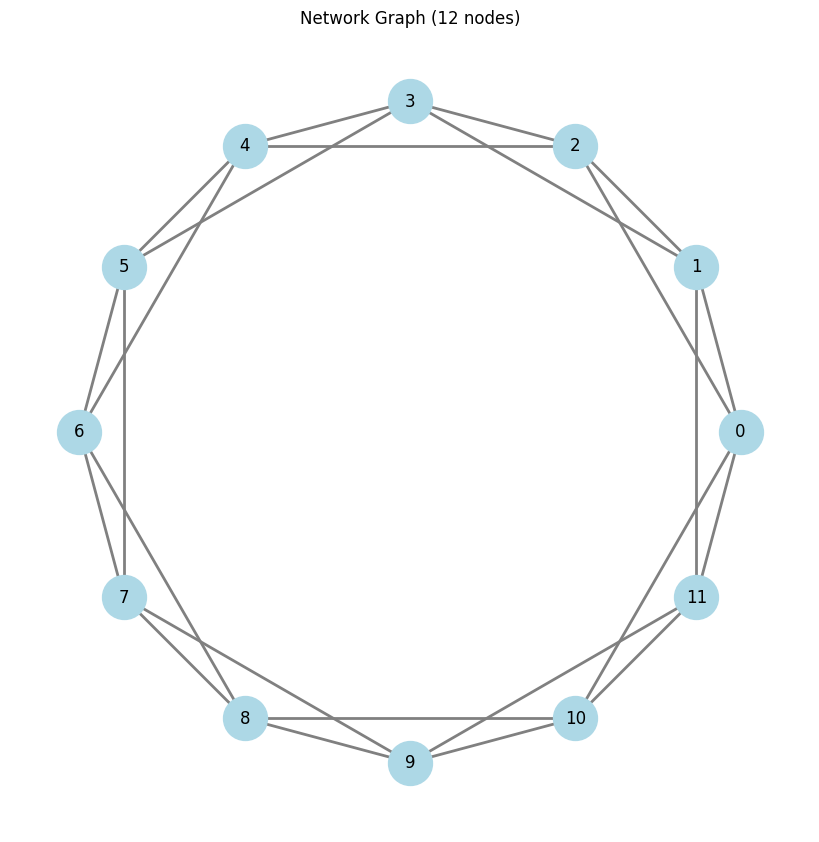

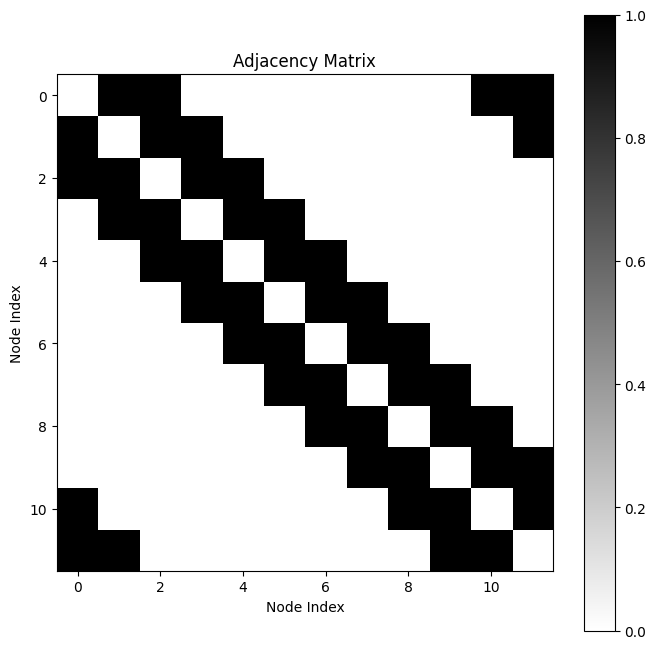

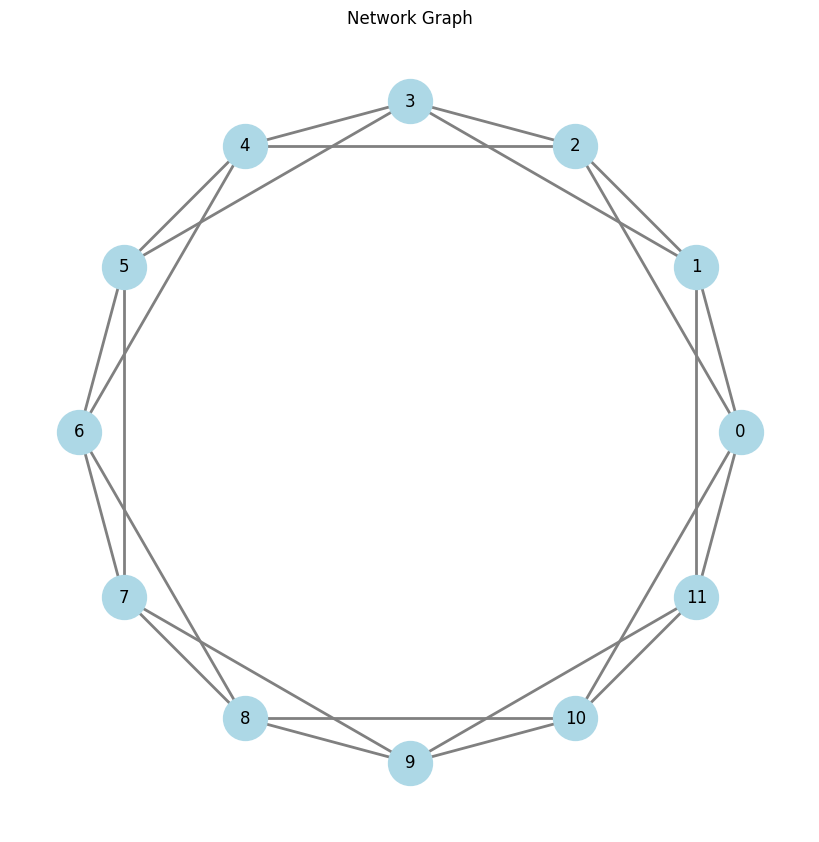

Unique subgroups of pairs as np.array:
[array([[10, 11],
       [ 6,  7],
       [ 4,  5],
       [ 0,  2],
       [ 8,  9],
       [ 1,  3]]), array([[ 9, 10],
       [ 1,  2],
       [ 3,  4],
       [ 0, 11],
       [ 5,  6],
       [ 7,  8]]), array([[ 1,  2],
       [ 3,  4],
       [ 8, 10],
       [ 7,  9],
       [ 5,  6],
       [ 0, 11]]), array([[ 8, 10],
       [ 6,  7],
       [ 4,  5],
       [ 0,  2],
       [ 9, 11],
       [ 1,  3]]), array([[ 9, 10],
       [ 2,  4],
       [ 6,  8],
       [ 5,  7],
       [ 1,  3],
       [ 0, 11]]), array([[ 0,  1],
       [ 2,  4],
       [10, 11],
       [ 6,  8],
       [ 7,  9],
       [ 3,  5]]), array([[ 0,  1],
       [ 4,  6],
       [ 8, 10],
       [ 5,  7],
       [ 2,  3],
       [ 9, 11]]), array([[ 2,  4],
       [ 0, 10],
       [ 5,  6],
       [ 9, 11],
       [ 1,  3],
       [ 7,  8]]), array([[ 0, 10],
       [ 1, 11],
       [ 2,  3],
       [ 6,  7],
       [ 4,  5],
       [ 8,  9]]), array([[ 9, 10],
       

In [18]:
# Example adjacency matrix (0 indicates no connection, 1 indicates connection)
adj_matrix = np.array([[0,1,1,0,0,0,0,0,0,0,1,1],
                    [1,0,1,1,0,0,0,0,0,0,0,1],
                    [1,1,0,1,1,0,0,0,0,0,0,0],
                    [0,1,1,0,1,1,0,0,0,0,0,0],
                    [0,0,1,1,0,1,1,0,0,0,0,0],
                    [0,0,0,1,1,0,1,1,0,0,0,0],
                    [0,0,0,0,1,1,0,1,1,0,0,0],
                    [0,0,0,0,0,1,1,0,1,1,0,0],
                    [0,0,0,0,0,0,1,1,0,1,1,0],
                    [0,0,0,0,0,0,0,1,1,0,1,1],
                    [1,0,0,0,0,0,0,0,1,1,0,1],
                    [1,1,0,0,0,0,0,0,0,1,1,0]])

G = nx.from_numpy_array(adj_matrix)
pos = nx.circular_layout(G)

plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, edge_color='gray', width=2)
plt.title('Network Graph (12 nodes)')
plt.show()

plot_adjacency_matrix(adj_matrix)
plot_network_graph(adj_matrix)

# Find all possible combinations of two-node connected subgroups
num_pairs = 6
subgroups = find_two_node_subgroups(adj_matrix, num_pairs)
print("Unique subgroups of pairs as np.array:")
print(subgroups)
print(len(subgroups))

In [7]:
n=6
objects = list(range(n))
unique_pairs = generate_pairs(objects)

# Output the result
#print(f"Number of unique ways to form pairs: {len(unique_pairs)}")
len(unique_pairs)

# If you want to save the pairings as a file-> specify file name
file_name = 'pairs.txt'

# Open the file in write mode
with open(file_name, 'w') as file:
    for i, array in enumerate(unique_pairs):
        # Write array to file
        #uncomment if you want to save
        #np.savetxt(file, array, fmt='%d')
        # Add a separator between arrays

        file.write('\n---\n')

print(f"List of arrays saved to {file_name}")

List of arrays saved to pairs.txt


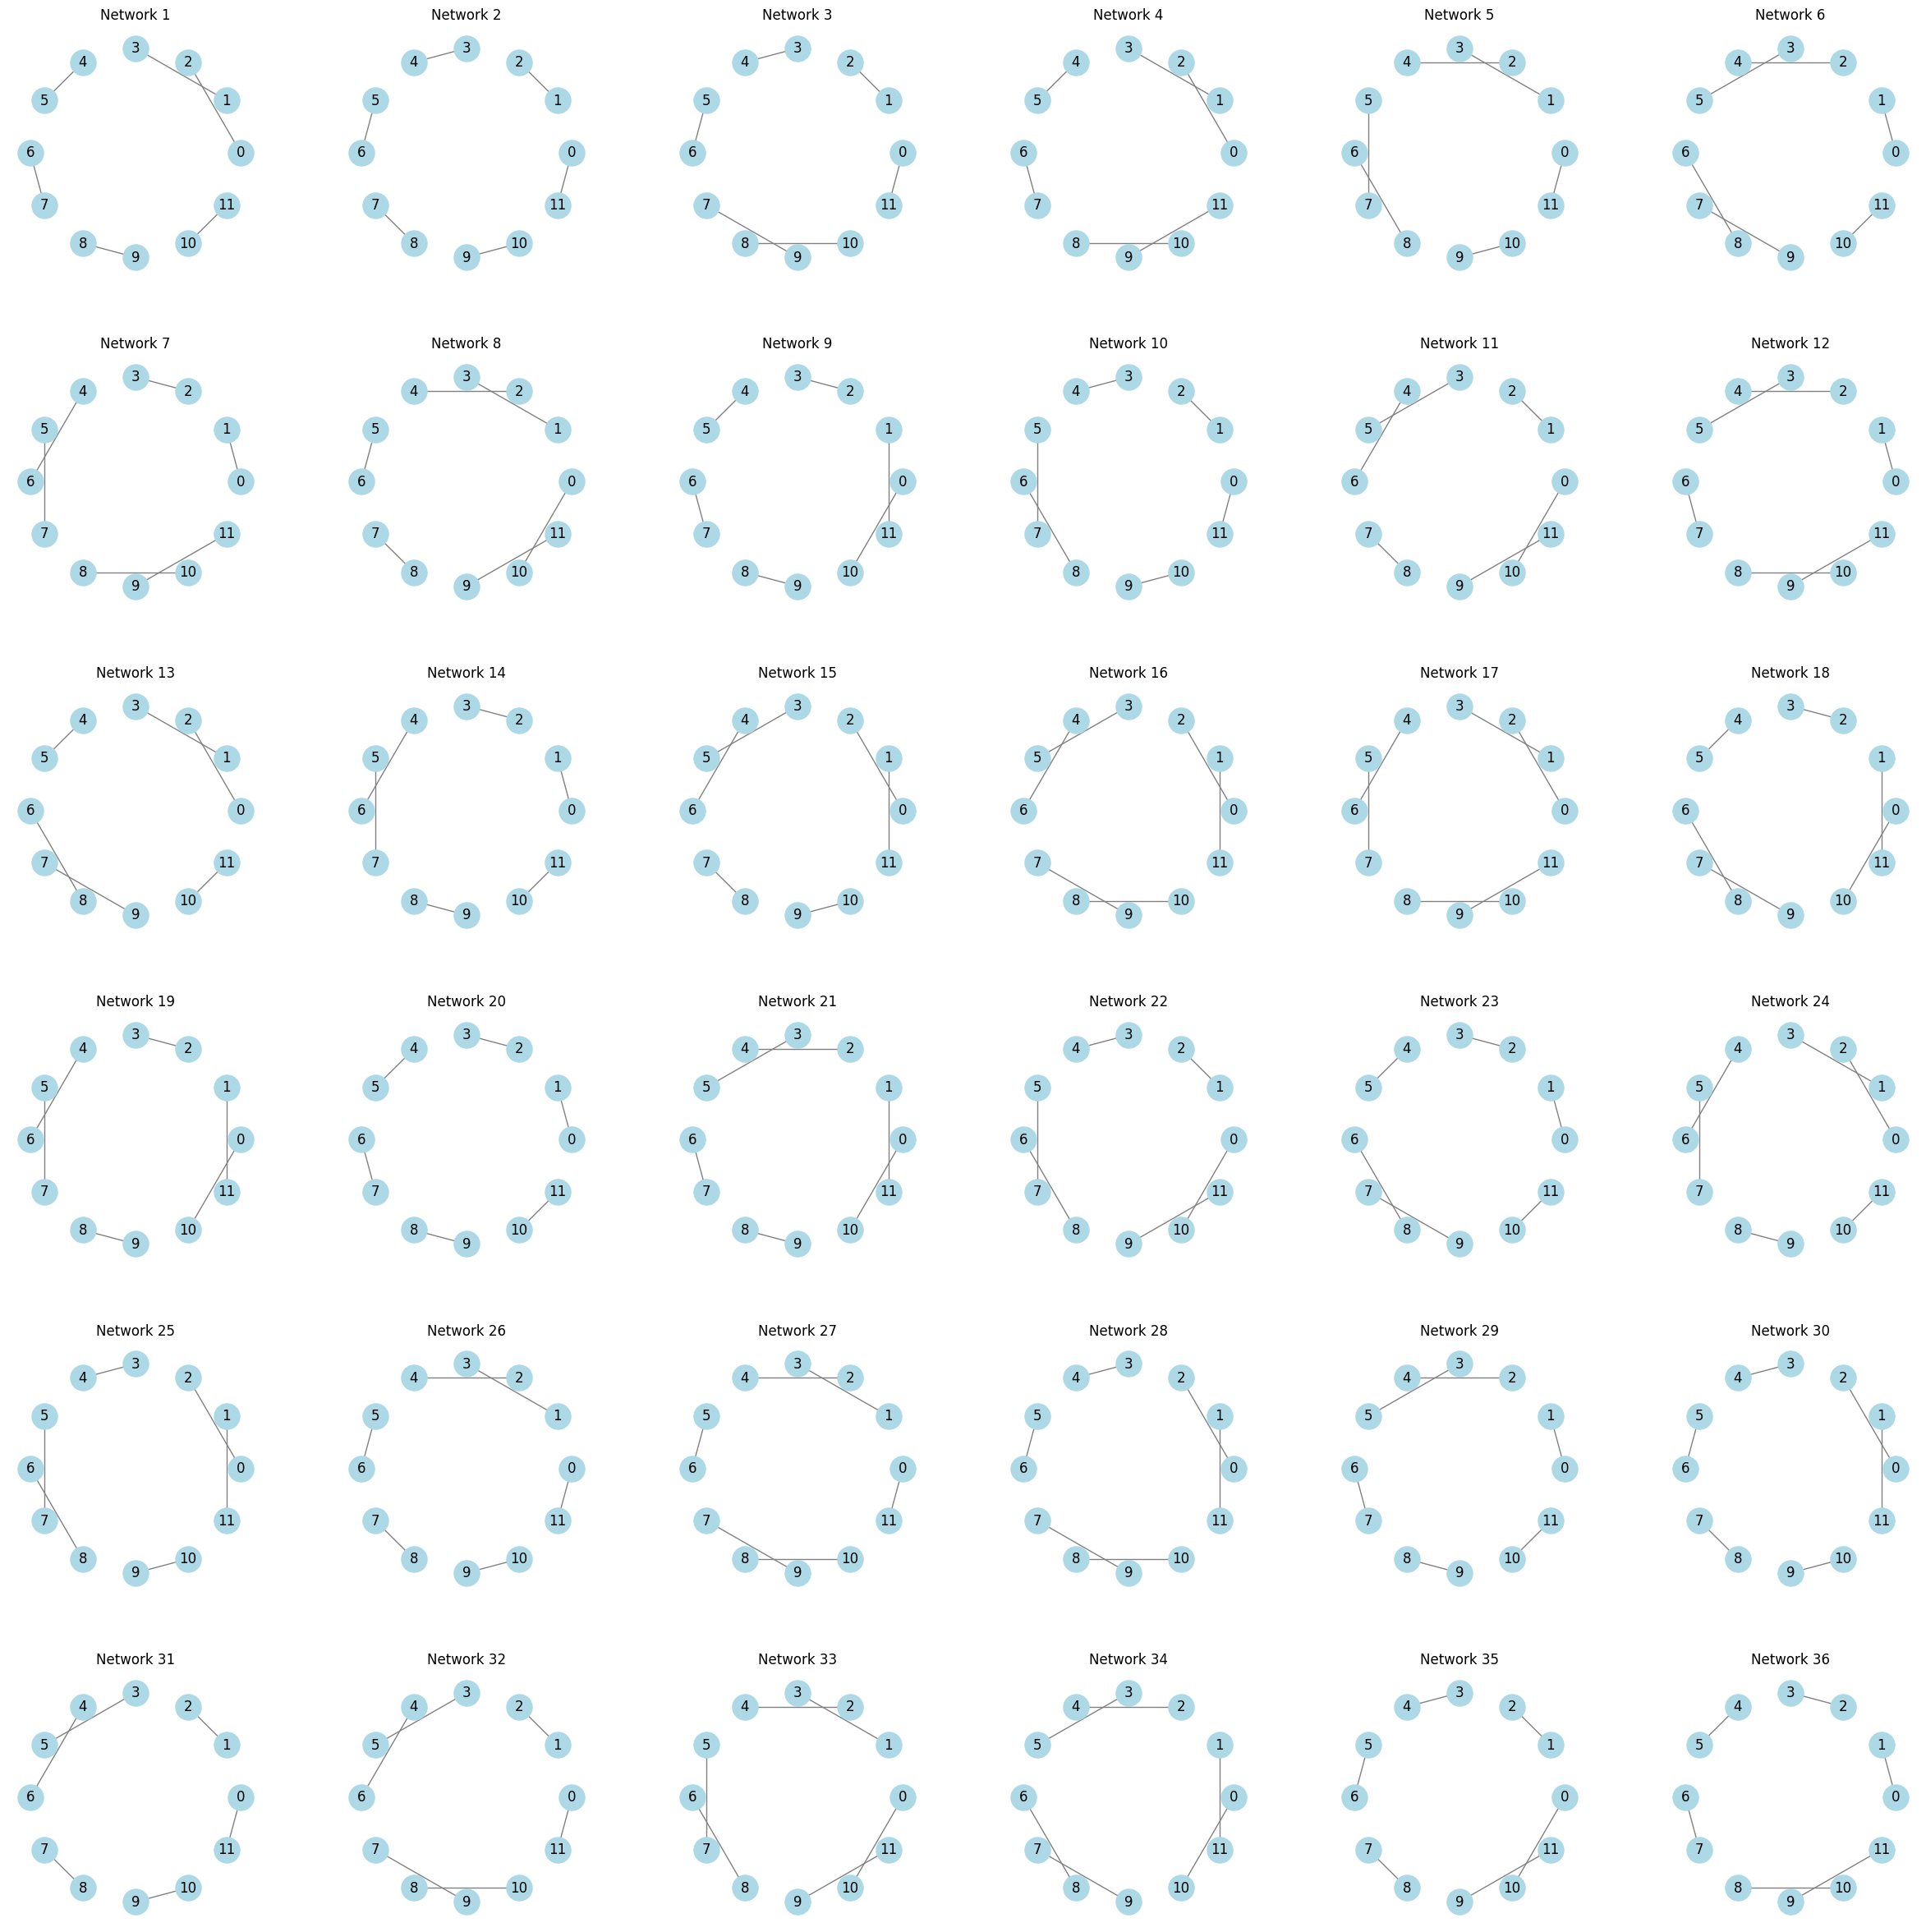

In [8]:
list_of_pairs = subgroups
#Make rows and columns of the subplots match the number of pairs. For the above adj matrix that 36 configurations, hence 6x6
#nxm=6x6
n=6
m=6
fig, axes = plt.subplots(n, m, figsize=(30, 30))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Function to visualize a graph from a list of pairs
def visualize_network(pairs, ax, title):
    G = nx.Graph()
    G.add_edges_from(pairs)
    node_order = list(range(12))

# Calculate positions for each node in a circle
    angle = 2 * np.pi / len(node_order)
    pos = {node: (np.cos(i * angle), np.sin(i * angle)) for i, node in enumerate(node_order)}
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=500, edge_color='gray', ax=ax)
    ax.set_title(title, fontsize=12)

# Plot each network in the grid
for idx, ax in enumerate(axes.flat):
    if idx < len(list_of_pairs):
        visualize_network(list_of_pairs[idx], ax, f"Network {idx + 1}")
    else:
        ax.axis('off')

#uncomment the code below if you want to save image.
#dpi is "dots per inch" and just refers to resolution
#tight means the saved figure does not have any white space
#plt.savefig("Connectivities.png",dpi=300, bbox_inches="tight")
plt.show()